## Imports

In [2]:
import csv
import pandas as pd
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import pmdarima.arima as pm

from box_jenkins import stationarityCheck, basicPlots
from statsmodels.tsa.seasonal import seasonal_decompose

# Data

In [3]:
rawData = []
with open('crude-oil-daily.csv', newline='') as csvfile:
  reader = csv.reader(csvfile)
  for row in reader:
    rawData.append(row)

In [4]:
df = pd.DataFrame(rawData)
df.columns = ['date', 'closingPx']
df = df.astype({'closingPx': 'float64', 'date': 'datetime64'})

# Initial Checks

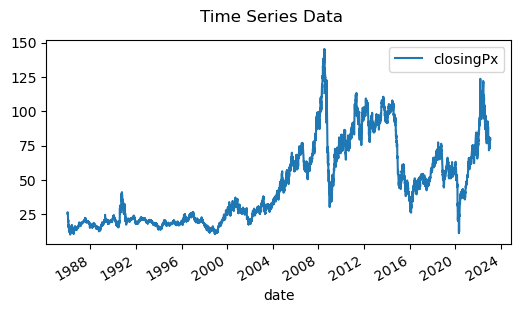

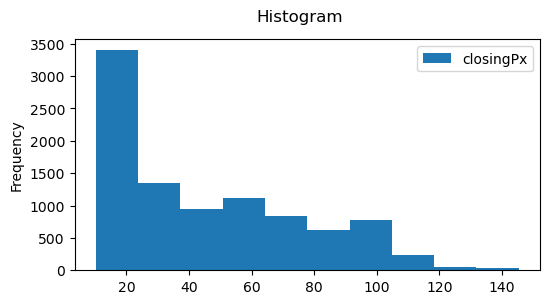

Dickey-Fuller Results
ADF Statistic: -2.006284
p-value: 0.283825
Critical Test Statistics Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


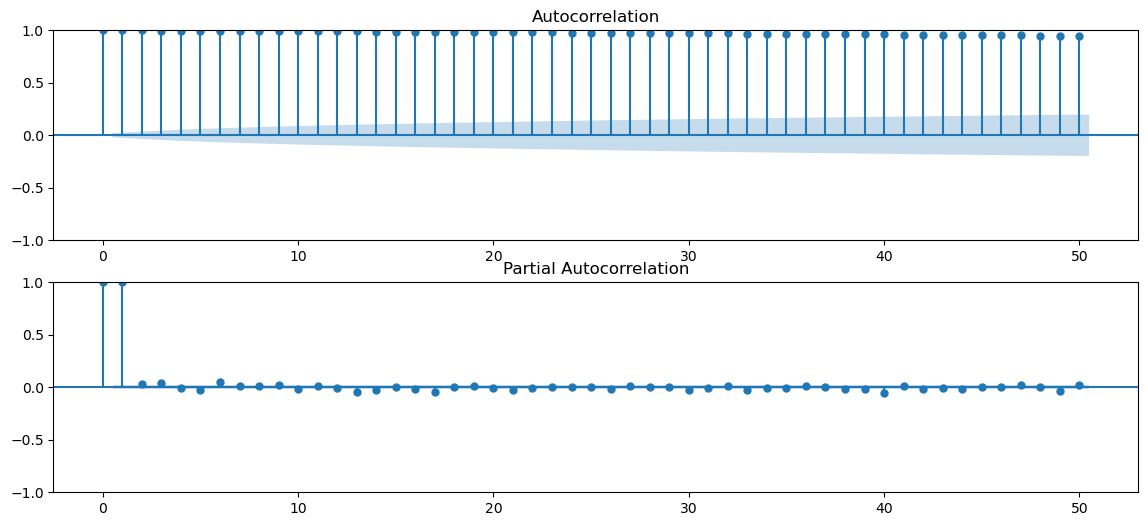

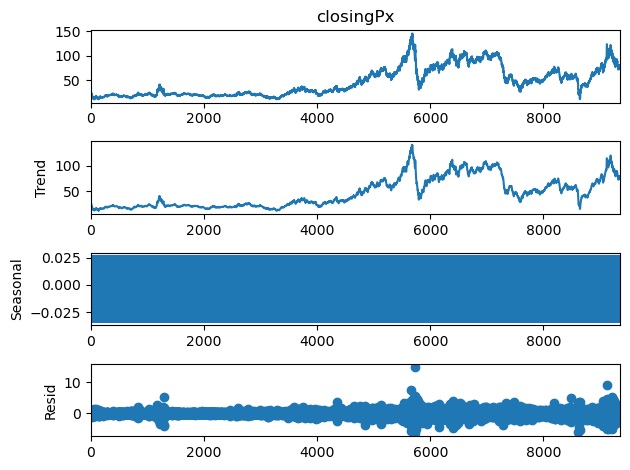

In [5]:
period=5

basicPlots(df, 'date', 'closingPx')
stationarityCheck(df['closingPx'])
decomp = seasonal_decompose(df.closingPx, period=period)
decomp.plot()
plt.show()


# Differencing

In [6]:
diff = df[['closingPx']].diff().diff(period)
diff.dropna(inplace=True)

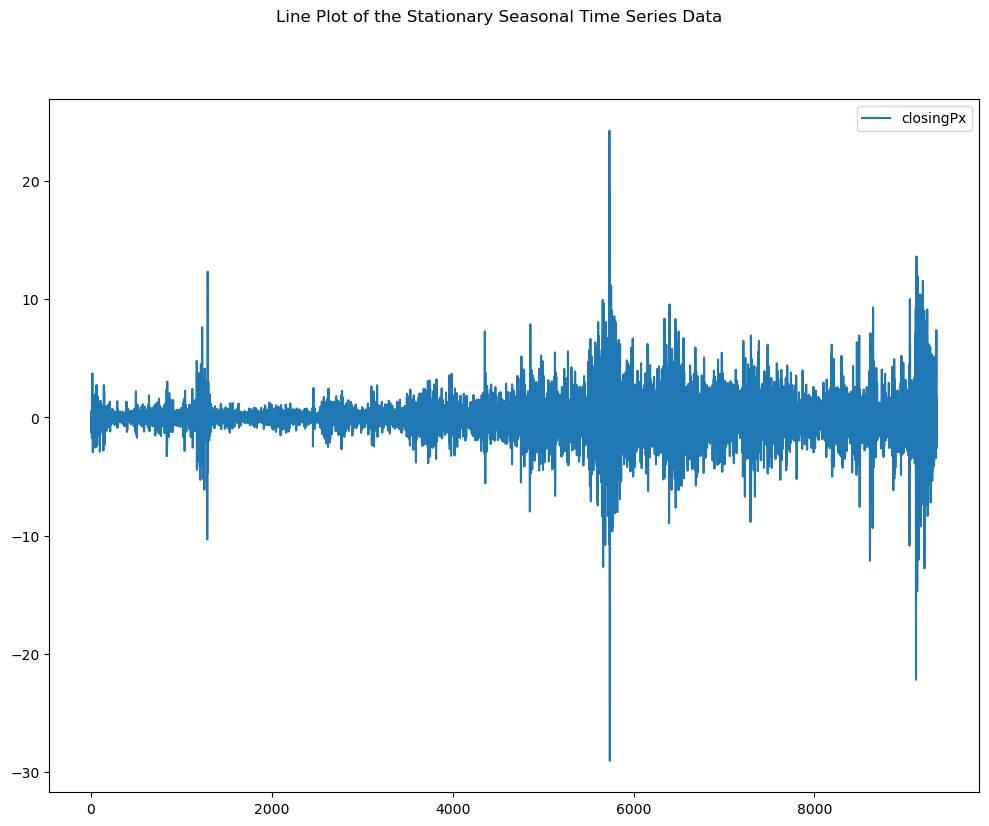

In [7]:
# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Seasonal Time Series Data')
diff.plot(ax=ax)
plt.show()

# Check stationarity again

Dickey-Fuller Results
ADF Statistic: -24.558340
p-value: 0.000000
Critical Test Statistics Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


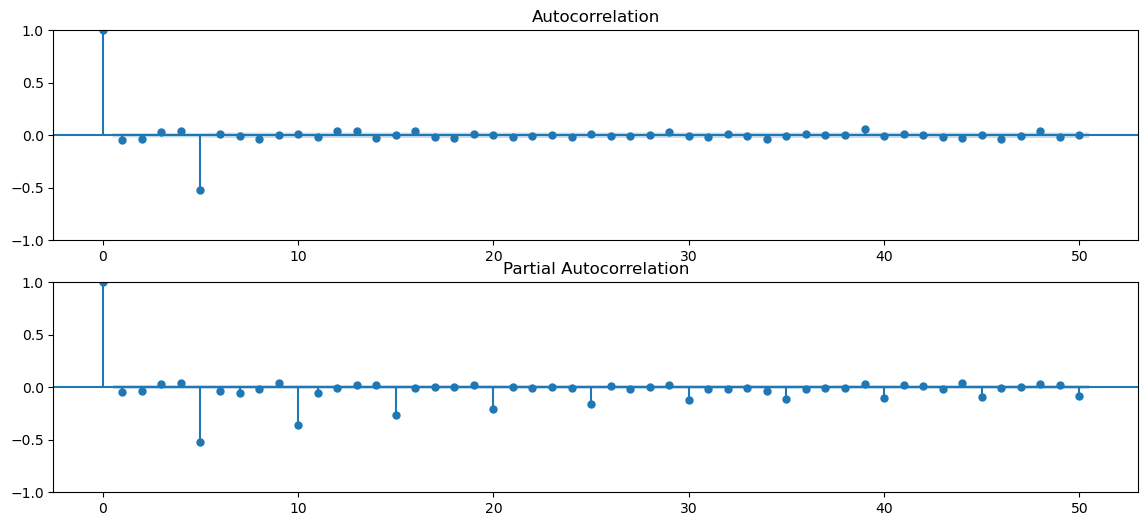

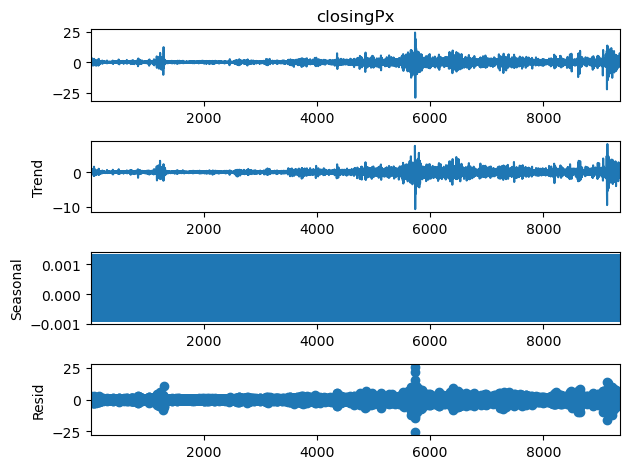

In [8]:
stationarityCheck(diff['closingPx'])
decomp = seasonal_decompose(diff.closingPx, period=period)
decomp.plot()
plt.show()

# Train ARIMA

In [28]:
train = df[:int(0.85*(len(df)))]
test = df[int(0.85*(len(df))):]

<AxesSubplot:>

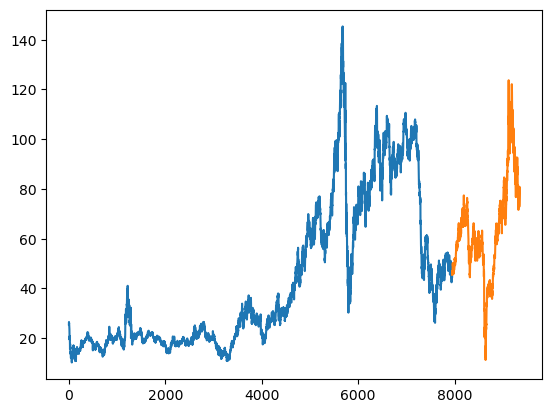

In [38]:
train.closingPx.plot()
test.closingPx.plot()

In [29]:
pm.auto_arima(train.closingPx, d=1, D=1, seasonal=True, m=period, trend='c', start_q=0, max_order=6, test='adf', stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(1,1,1)[5]             : AIC=inf, Time=10.59 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=30630.616, Time=0.16 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=28030.155, Time=1.10 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=7.10 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=30606.399, Time=0.39 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=26990.220, Time=1.74 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=12.42 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=7.23 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=27008.669, Time=1.30 sec
 ARIMA(2,1,0)(2,1,0)[5]             : AIC=26984.016, Time=2.08 sec
 ARIMA(2,1,0)(1,1,0)[5]             : AIC=28022.054, Time=1.33 sec
 ARIMA(2,1,0)(2,1,1)[5]             : AIC=inf, Time=16.71 sec
 ARIMA(3,1,0)(2,1,0)[5]             : AIC=26985.830, Time=2.58 sec
 ARIMA(2,1,1)(2,1,0)[5]             : AIC=26991.880, Time=5.00 sec
 ARIMA(1,1,1)(2,1,0)[5]             : AIC=inf,

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 5),
      suppress_warnings=True, trend='c', with_intercept=False)

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [31]:
model = SARIMAX(train.closingPx,order=(2,1,0),seasonal_order=(2,1,0,5))

In [32]:
results = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74127D+00    |proj g|=  2.20516D-01

At iterate    5    f=  1.69635D+00    |proj g|=  6.55187D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5      7      1     0     0   6.552D-07   1.696D+00
  F =   1.6963532587593684     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [33]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                         closingPx   No. Observations:                 7950
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 5)   Log Likelihood              -13486.008
Date:                           Wed, 22 Feb 2023   AIC                          26982.017
Time:                                   16:42:08   BIC                          27016.918
Sample:                                        0   HQIC                         26993.967
                                          - 7950                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0523      0.004    -11.726      0.000      -0.061      -0.044
ar.L2         -0.0321      0.006     -5.498      0.000      -0.044      -0.021
ar.S.L5       -0.7111      0.004   -167.567      0.000      -0.719      -0.703
ar.S.L10      -0.3503      0.005    -63.891      0.000      -0.361      -0.340
sigma2         1.7455      0.010    176.305      0.000       1.726       1.765
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             87019.73
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               9.40   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 640x480 with 4 Axes>,)

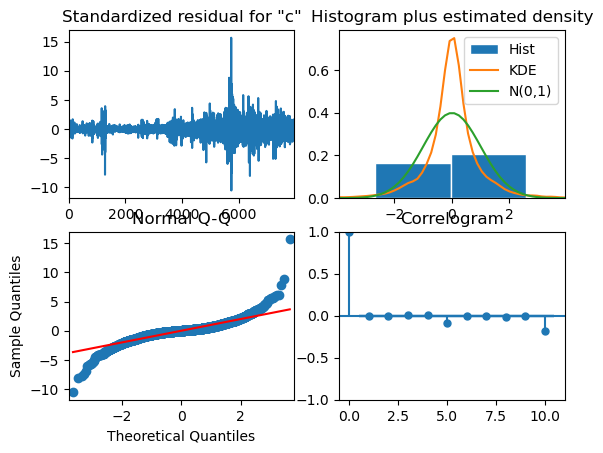

In [34]:
results.plot_diagnostics(),

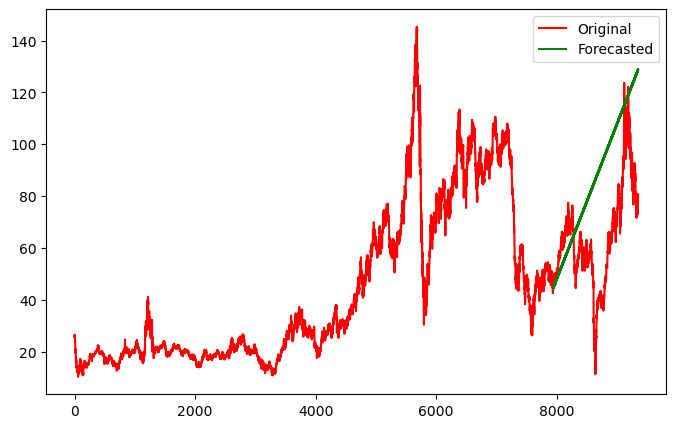

In [40]:
#Checking prediction value with test
forecast = results.get_forecast(steps=len(test))
mean = forecast.predicted_mean
conf_int = forecast.conf_int()
d = mean.index
plt.figure(figsize=(8,5))
# Plot past  levels
plt.plot(df.index, df.closingPx, label='Original', color = 'red')
# Prediction Mean
plt.plot(d, mean, label='Forecasted', color= 'green')
# Shade of space between  confidence intervals
#plt.fill_between(d, conf_int.iloc[:,0], conf_int.iloc[:,1],
#alpha=0.2, color= 'blue')
# Plot legend 
plt.legend()
plt.savefig('p')
plt.show()